In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'val'
test_path = 'test'

In [4]:
# useful for getting number of output classes
folders = glob('train/*')

In [5]:
folders

['train\\Healthy', 'train\\Unhealthy']

In [6]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (224,224,3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Flatten(),
                                    ##
                                    tf.keras.layers.Dense(128,activation = 'relu'),
                                    ##
                                    tf.keras.layers.Dense(1,activation = 'sigmoid')
                                    ])

In [7]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               23888000  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [8]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [9]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   ) 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
# Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 ) # set as training data

Found 4693 images belonging to 2 classes.


In [11]:
valid_generator = train_datagen.flow_from_directory('val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            )

Found 1564 images belonging to 2 classes.


In [12]:
test_generator = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            )

Found 1564 images belonging to 2 classes.


In [13]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator)
)

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
147/147 [==============================] - 56s 371ms/step - loss: 0.0660 - accuracy: 0.9872 - val_loss: 5.1870e-06 - val_accuracy: 1.0000
Epoch 2/5
147/147 [==============================] - 55s 372ms/step - loss: 1.2656e-06 - accuracy: 1.0000 - val_loss: 1.6677e-06 - val_accuracy: 1.0000
Epoch 3/5
147/147 [==============================] - 56s 384ms/step - loss: 7.0430e-07 - accuracy: 1.0000 - val_loss: 1.9881e-06 - val_accuracy: 1.0000
Epoch 4/5
147/147 [==============================] - 56s 379ms/step - loss: 4.5582e-07 - accuracy: 1.0000 - val_loss: 1.0348e-06 - val_accuracy: 1.0000
Epoch 5/5
147/147 [==============================] - 56s 378ms/step - loss: 2.4131e-07 - accuracy: 1.0000 - val_loss: 9.4845e-07 - val_accuracy: 1.0000


In [14]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('logs/phc_shallowCNN.h5')

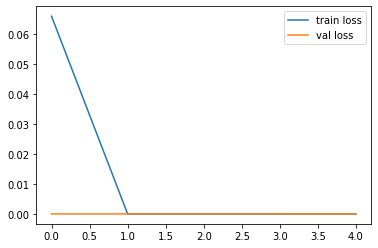

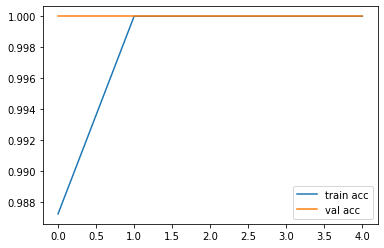

<Figure size 432x288 with 0 Axes>

In [15]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

1564/1564 - 5s - loss: 1.0740e-06 - accuracy: 1.0000

Test accuracy: 1.0

Test loss: 1.0740362768046907e-06


test accuracy : 100.0


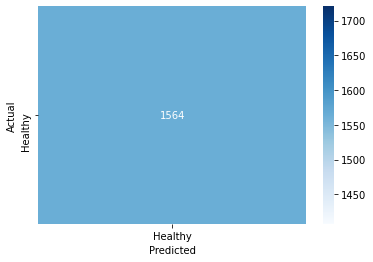

In [17]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('logs/phc_shallowCNN.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
   X_test,Y_test = test_generator.next()
   y_prob.append(model.predict(X_test))
   y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))